In [49]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
sns.set()

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput'

# Decide on experiment's configuration

layers.0.weight tensor([[2.]], device='cuda:0') 



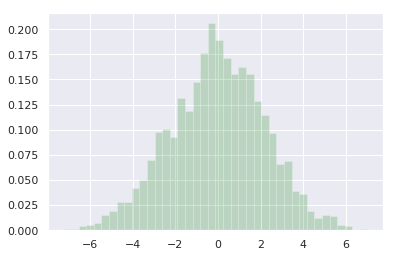

In [50]:
DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 2000
N_IS_SAMPLES = 1000
WITH_BIASX = False
WITH_LOGVARX = False

FRAC_VAL = 0.2

W_TRUE = {}
B_TRUE = {}

W_TRUE[0] = [[2.]]


if WITH_LOGVARX:
    assert len(W_TRUE) == N_DECODER_LAYERS + 1, len(W_TRUE)
else:
    assert len(W_TRUE) == N_DECODER_LAYERS

WITH_BIASZ = True
WITH_LOGVARZ = True

decoder_true = toynn.make_decoder_true(
    w_true=W_TRUE, b_true=B_TRUE, latent_dim=LATENT_DIM, 
    data_dim=DATA_DIM, n_layers=N_DECODER_LAYERS,
    nonlinearity=NONLINEARITY, with_biasx=WITH_BIASX, with_logvarx=WITH_LOGVARX)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Inspect generation of synthetic data from decoder_true

layers.0.weight tensor([[2.]], device='cuda:0') 



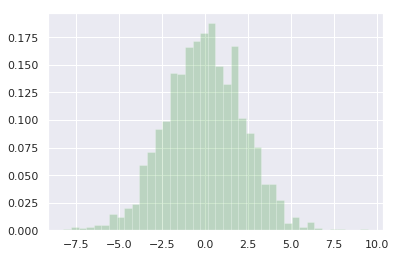

In [51]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    
generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Get synthetized data and corresponding MLE

In [52]:
dataset_path = glob.glob(f'{OUTPUT}/synthetic/dataset.npy')[0]
dataset = np.load(dataset_path)
n_train = int((1 - FRAC_VAL) * N_SAMPLES)

# Training set

train = dataset[:n_train,]
train = torch.Tensor(train)

sig2 = torch.mean((train) ** 2, dim=0)
w_mle_square = sig2 - 1 
w_mle = torch.sqrt(w_mle_square)
train_w_mle = torch.Tensor(w_mle).to(DEVICE)

train_negloglikelihood = toylosses.fa_negloglikelihood(train_w_mle, train)
train_negloglikelihood = train_negloglikelihood.cpu().numpy()
print('The maximum likelihood estimator on this train dataset is:')
print(train_w_mle)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_negloglikelihood)

# The end value of the VEM
# Test
print('And VAE:')
print(toylosses.fa_negloglikelihood(torch.Tensor([-1.0752]), train))

print('And VEM:')
print(toylosses.fa_negloglikelihood(torch.Tensor([-2.4323]), train))

#print('And VEGAN:')
#print(toylosses.fa_negloglikelihood(torch.Tensor([-2.9798]), train))

# Validation set
print('\n')
val = dataset[n_train:,]
val = torch.Tensor(val)

sig2 = torch.mean((val) ** 2, dim=0)
w_mle_square = sig2 - 1 
w_mle = torch.sqrt(w_mle_square)
val_w_mle = torch.Tensor(w_mle).to(DEVICE)

val_negloglikelihood = toylosses.fa_negloglikelihood(val_w_mle, val)
val_negloglikelihood = val_negloglikelihood.cpu().numpy()
print('The maximum likelihood estimator on this val dataset is:')
print(val_w_mle)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_negloglikelihood)

print('!! train_data = ', train)

The maximum likelihood estimator on this train dataset is:
tensor([1.9595], device='cuda:0')
The corresponding value for the negative log-likelihood for the training set is:
[2.2073736]
And VAE:
tensor([2.4254])
And VEM:
tensor([2.2358])


The maximum likelihood estimator on this val dataset is:
tensor([1.9359], device='cuda:0')
The corresponding value for the negative log-likelihood for the validation set is:
[2.1977503]
!! train_data =  tensor([[-0.6277],
        [-0.7071],
        [ 1.3507],
        ...,
        [ 3.9086],
        [-0.6667],
        [ 1.6402]])


In [53]:
# TODO(nina): Add a comparison to a FA?

# Inspect results from standard VAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.3884]], device='cuda:0') 



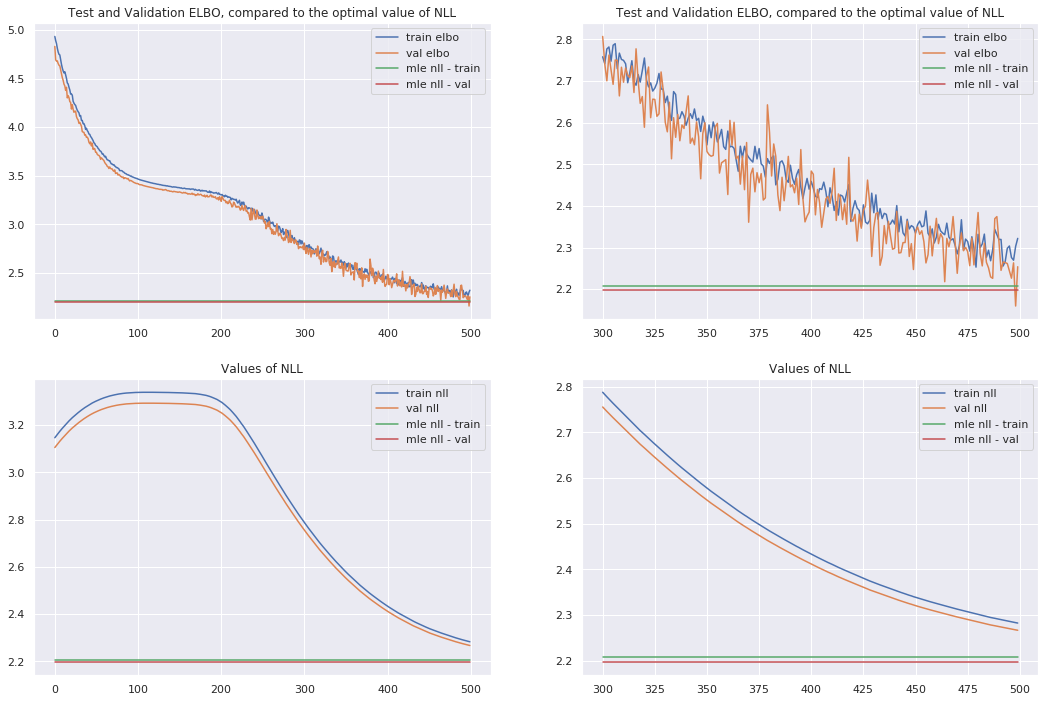

In [54]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vae/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
train_losses_path = glob.glob(f'{OUTPUT}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vae/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
val_losses_total = [loss['total'] for loss in val_losses_all_epochs]

train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

n_epochs = len(train_losses_total)
epochs = range(n_epochs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax = axes[0, 0]
ax.plot(epochs, train_losses_total, label='train elbo')
ax.plot(epochs, val_losses_total, label='val elbo')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[0, 1]
ax.plot(epochs[300:], train_losses_total[300:], label='train elbo')
ax.plot(epochs[300:], val_losses_total[300:], label='val elbo')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[1, 0]
ax.plot(epochs, train_nll, label='train nll')
ax.plot(epochs, val_nll, label='val nll')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()

ax = axes[1, 1]
ax.plot(epochs[300:], train_nll[300:], label='train nll')
ax.plot(epochs[300:], val_nll[300:], label='val nll')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()


#ax.plot(range(90, n_epochs), train_losses_total[90:])

#ax = axes[2]
#ax.plot(range(160, n_epochs), train_losses_total[160:])

#print('Last losses:')
#print(train_losses_total[-5:])

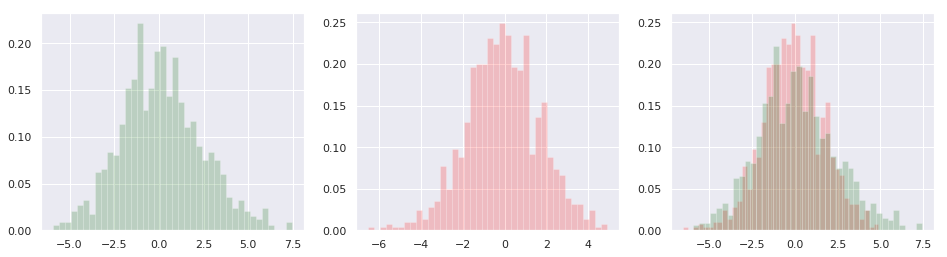

In [55]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_x, color='red', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from VEM

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.8160]], device='cuda:0') 

VEM last train nll =  tensor([[2.2110]], requires_grad=True)
VEM train nll =  tensor([[2.2110]])


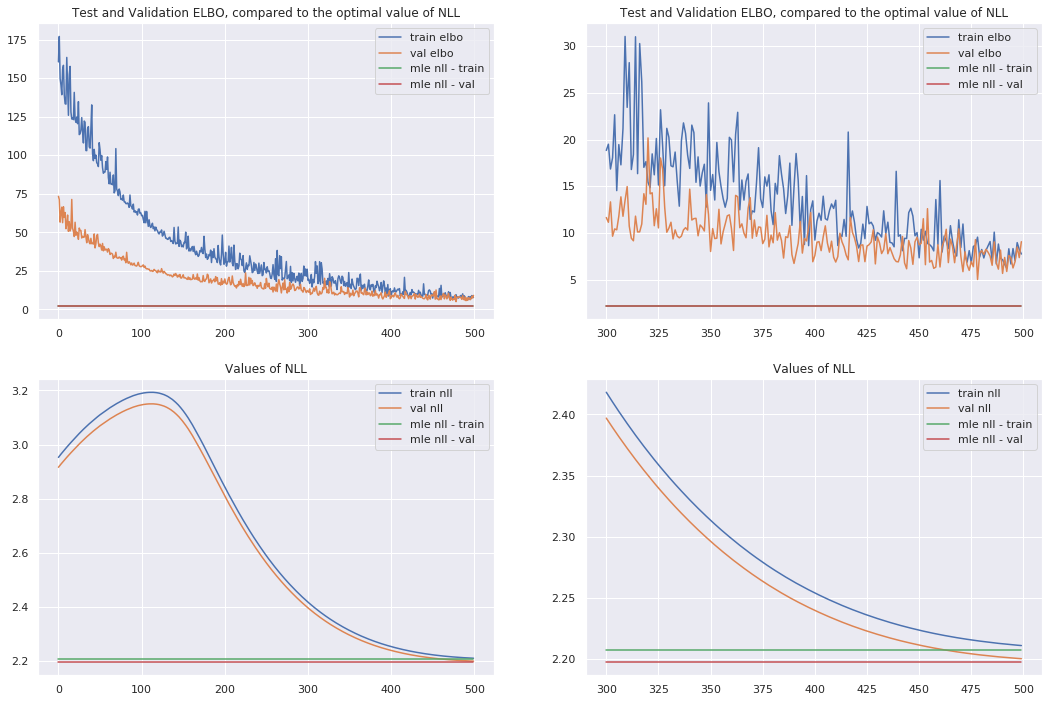

In [56]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vem/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    weight = param.data[[0]]
    
train_losses_path = glob.glob(f'{OUTPUT}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vem/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
val_losses_total = [loss['total'] for loss in val_losses_all_epochs]

train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

print('VEM last train nll = ', train_nll[-1])
print('VEM train nll = ', toylosses.fa_negloglikelihood(weight, train))

n_epochs = len(train_losses_total)
epochs = range(n_epochs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax = axes[0, 0]
ax.plot(epochs, train_losses_total, label='train elbo')
ax.plot(epochs, val_losses_total, label='val elbo')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[0, 1]
ax.plot(epochs[300:], train_losses_total[300:], label='train elbo')
ax.plot(epochs[300:], val_losses_total[300:], label='val elbo')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[1, 0]
ax.plot(epochs, train_nll, label='train nll')
ax.plot(epochs, val_nll, label='val nll')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()

ax = axes[1, 1]
ax.plot(epochs[300:], train_nll[300:], label='train nll')
ax.plot(epochs[300:], val_nll[300:], label='val nll')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()
#print('Last losses:')
#print(train_losses_total[-5:]#)

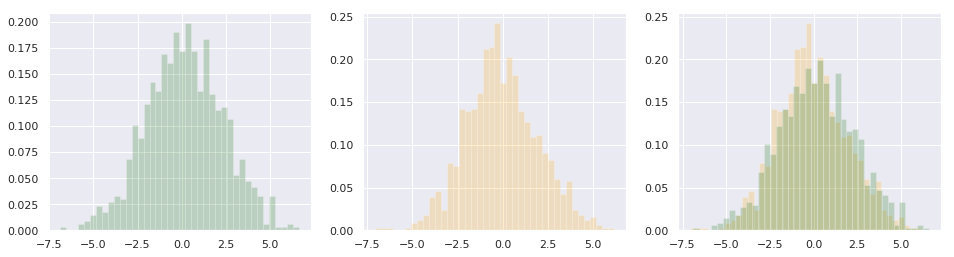

In [57]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)


ax = axes[1]
toyvis.plot_data(generated_x, color='orange', ax=ax)


ax = axes[2]
toyvis.plot_data(generated_x, color='orange', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from VEGAN

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.5344]], device='cuda:0') 



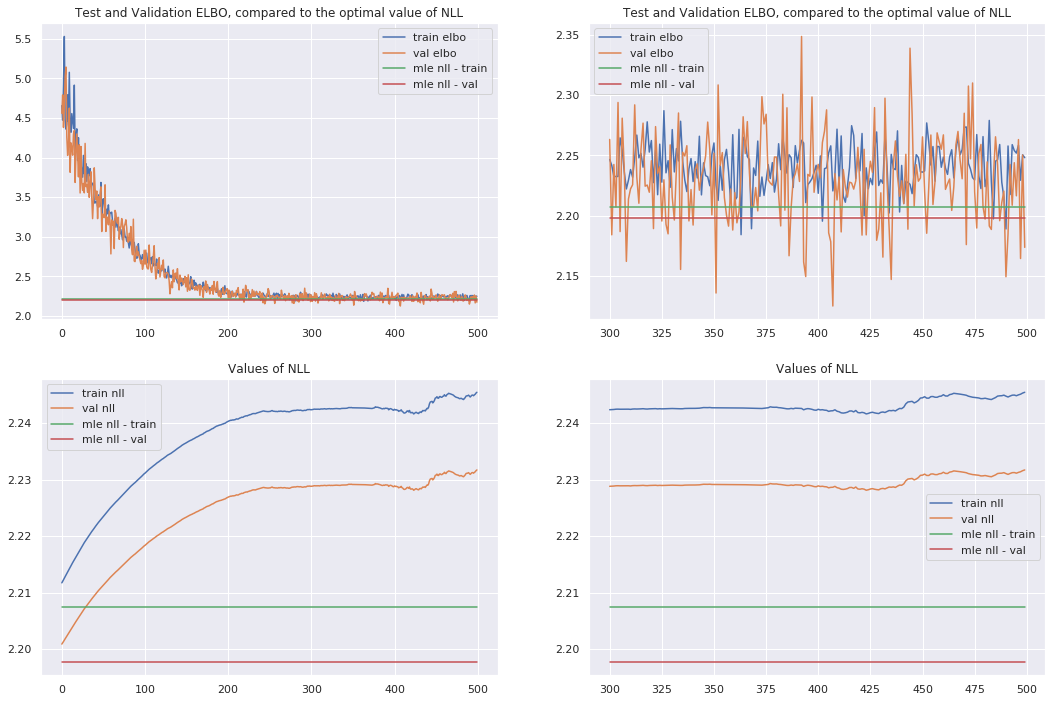

In [58]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vegan/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
train_losses_path = glob.glob(f'{OUTPUT}/train_vegan/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vegan/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
val_losses_total = [loss['total'] for loss in val_losses_all_epochs]

train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

n_epochs = len(train_losses_total)
epochs = range(n_epochs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

ax = axes[0, 0]
ax.plot(epochs, train_losses_total, label='train elbo')
ax.plot(epochs, val_losses_total, label='val elbo')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[0, 1]
ax.plot(epochs[300:], train_losses_total[300:], label='train elbo')
ax.plot(epochs[300:], val_losses_total[300:], label='val elbo')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[1, 0]
ax.plot(epochs, train_nll, label='train nll')
ax.plot(epochs, val_nll, label='val nll')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()

ax = axes[1, 1]
ax.plot(epochs[300:], train_nll[300:], label='train nll')
ax.plot(epochs[300:], val_nll[300:], label='val nll')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Values of NLL')
ax.legend()



#print('Last losses:')
#print(train_losses_total[-5:]#)

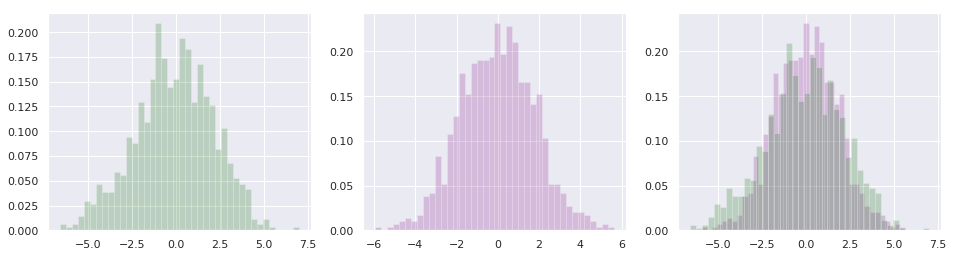

In [59]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)


ax = axes[1]
toyvis.plot_data(generated_x, color='purple', ax=ax)


ax = axes[2]
toyvis.plot_data(generated_x, color='purple', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Comparaison of NLL

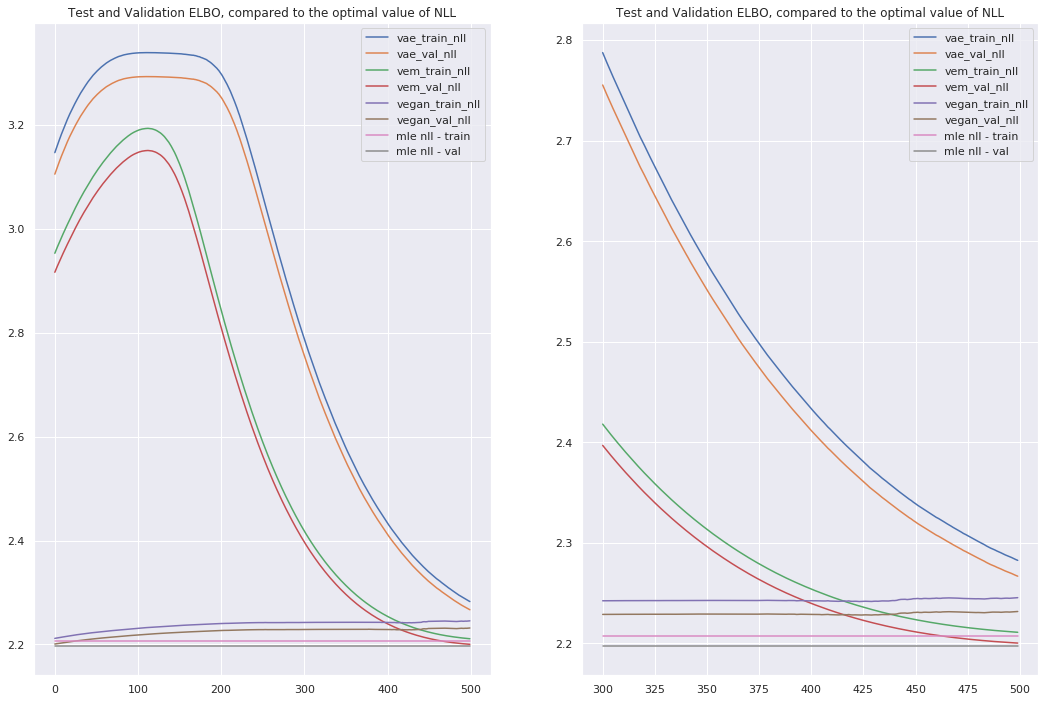

In [62]:
train_losses_path = glob.glob(f'{OUTPUT}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vae/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

vae_train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
vae_val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

train_losses_path = glob.glob(f'{OUTPUT}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vem/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

vem_train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
vem_val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

train_losses_path = glob.glob(f'{OUTPUT}/train_vegan/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vegan/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

vegan_train_nll = [loss['negloglikelihood'] for loss in train_losses_all_epochs]
vegan_val_nll = [loss['negloglikelihood'] for loss in val_losses_all_epochs]

n_epochs = len(train_losses_total)
epochs = range(n_epochs)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

ax = axes[0]
ax.plot(epochs, vae_train_nll, label='vae_train_nll')
ax.plot(epochs, vae_val_nll, label='vae_val_nll')

ax.plot(epochs, vem_train_nll, label='vem_train_nll')
ax.plot(epochs, vem_val_nll, label='vem_val_nll')

ax.plot(epochs, vegan_train_nll, label='vegan_train_nll')
ax.plot(epochs, vegan_val_nll, label='vegan_val_nll')

ax.plot(epochs, np.repeat(train_negloglikelihood, n_epochs), label='mle nll - train')
ax.plot(epochs, np.repeat(val_negloglikelihood, n_epochs), label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

ax = axes[1]
ax.plot(epochs[300:], vae_train_nll[300:], label='vae_train_nll')
ax.plot(epochs[300:], vae_val_nll[300:], label='vae_val_nll')

ax.plot(epochs[300:], vem_train_nll[300:], label='vem_train_nll')
ax.plot(epochs[300:], vem_val_nll[300:], label='vem_val_nll')

ax.plot(epochs[300:], vegan_train_nll[300:], label='vegan_train_nll')
ax.plot(epochs[300:], vegan_val_nll[300:], label='vegan_val_nll')

ax.plot(epochs[300:], np.repeat(train_negloglikelihood, n_epochs)[300:], label='mle nll - train')
ax.plot(epochs[300:], np.repeat(val_negloglikelihood, n_epochs)[300:], label='mle nll - val')
ax.set_title('Test and Validation ELBO, compared to the optimal value of NLL')
ax.legend()

# Print pipeline logs

In [37]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-11 20:36:40.619998.txt

2019-05-11 20:36:40,620 root         INFO     start
2019-05-11 20:36:40,634 luigi        INFO     logging configured by default settings
2019-05-11 20:36:40,659 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-11 20:36:40,661 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-11 20:36:40,661 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   TrainVEM__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   MakeDataSet__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   Trai